# 1. Anomaly detection
In this sexercise, you will implement collaborative filtering learning algorithm and apply it to a dataset of movie ratings. This dataset consists of ratings on a scale of 1 to 5. The dataset has $n_u$ = 943 users, and $n_m$ = 1682 movies

In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import pandas as pd

from pandas import DataFrame as df

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.rendered_html { font-size: 15px; }</style>"))

## 2.1 Movie ratings dataset

In [3]:
# =============== Part 1: Loading movie ratings dataset ================
# You will start by loading the movie ratings dataset to understand the
# structure of the data.

In [4]:
data = sio.loadmat('ex8_movies.mat')

In [5]:
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Y', 'R'])

In [6]:
# Store data into respective variables
Y = data['Y']
R = data['R']

In [7]:
Y.shape, R.shape

((1682, 943), (1682, 943))

$Y$ is a 1682 x 943 matrix containing 1682 movies on rating of 1-5 on 943 users  
$R$ is a 1682 x 943 matrix, where $R(i, j)$ = 1 if and only if user $j$ gave a rating to movie $i$

In [8]:
# From the matrix, we can compute statistics like average rating
print('Average rating for movie 1 (Toy Story): %f / 5' %np.mean(Y[0, R[0, :]==1]))

Average rating for movie 1 (Toy Story): 3.878319 / 5


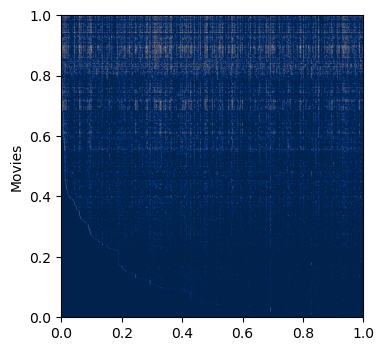

In [9]:
# We can "visualize" the ratings matrix by plotting it with imagesc
plt.figure(dpi=100)
plt.imshow(Y, extent=[0, 1, 0, 1], cmap='cividis')
plt.ylabel('Movies')
plt.xlabel
plt.show()

## 2.2 Collaborative filtering learning algorithm

### 2.2.1 Collaborative filtering cost function
The collaborative filtering cost function (without regularization) is given by:
$$J(x^{(1)}, ...x^{(n_m)}, \theta^{(1)}, ...\theta^{(n_u)}) = \frac12 \sum_{(i, j):r(i, j)=1} ((\theta^{(j)})^T x^{(i)} - y^{(i, j)})^2$$

In [10]:
# ============ Part 2: Collaborative Filtering Cost Function ===========
# You will now implement the cost function for collaborative filtering.
# To help you debug your cost function, we have included set of weights that we trained on that.

In [11]:
# The reshaping is done to cater to computeNumericalGradient, actually python function can have n-D argument passed
def cofiCostFunc(params, Y, R, num_users, num_movies, num_features, lambd=0):
    '''
    COFICOSTFUNC Collaborative filtering cost function
       J = COFICOSTFUNC(X, Theta, Y, R, lambda) 
       returns the cost for the collaborative filtering problem.
    '''
    # Reshape nn_params back to theta1 and theta2
    X = params[:(num_movies*(num_features))].reshape(num_movies, -1, order='F')
    Theta = params[(num_movies*(num_features)):].reshape(num_users, -1, order='F')      
    
    # Hypothesis
    h = X@Theta.T
        
    # Cost function
    cost = 1/2 * np.sum(((h-Y)**2)[R==1]) + lambd/2 * np.sum(Theta**2) + lambd/2 * np.sum(X**2)
    
    return cost

In [12]:
# Load pre-trained weights (X, Theta, num_users, num_movies, num_features)
data = sio.loadmat('ex8_movieParams.mat')

In [13]:
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Theta', 'num_users', 'num_movies', 'num_features'])

In [14]:
# Store values into respective variables
X = data['X']
Theta = data['Theta']

In [15]:
X.shape, Theta.shape

((1682, 10), (943, 10))

What are X and Theta?  

The $i$-th row of $X$ corresponds to the feature vectore $x^{(i)}$ for the $i$-th movie  
The $j$-th row of $Theta$ corresponds to one parameter $\Theta^{(j)}$, for the $j$-th user  
For the purpose of this exercise, $n$ = 10

In [16]:
# Reduce the data set size so that it runs faster
num_users = 4
num_movies = 5
num_features = 3

In [17]:
X = X[:num_movies, :num_features]
Theta = Theta[:num_users, :num_features]
Y = Y[:num_movies, :num_users]
R = R[:num_movies, :num_users]

In [18]:
X.shape, Theta.shape, Y.shape, R.shape

((5, 3), (4, 3), (5, 4), (5, 4))

In [19]:
params = np.hstack([X.ravel(order='F'), Theta.ravel(order='F')])

In [20]:
# Evaluate cost function
J = cofiCostFunc(params, Y, R, num_users, num_movies, num_features)

In [21]:
print('Cost at loaded parameters: %f' %J)
print('(this value should be about 22.22)')

Cost at loaded parameters: 22.224604
(this value should be about 22.22)


### 2.2.2 Colaborative filtering gradient
The gradient of cost function is given by:
$$\frac{\partial J}{\partial x_k^{(i)}} =
\sum_{j:r(i, j)=1} \left( (\theta^{(j)})^T x^{(i)}-y^{(i, j)}\right)\theta_k^{(j)}$$

$$\frac{\partial J}{\partial \theta_k^{(i)}} =
\sum_{j:r(i, j)=1} \left( (\theta^{(j)})^T x^{(i)}-y^{(i, j)}\right)x_k^{(j)}$$

In [22]:
# ============== Part 3: Collaborative Filtering Gradient ==============
# Once your cost function matches up with ours, you should now implement the collaborative filtering gradient function

In [23]:
def cofiGrad(params, Y, R, num_users, num_movies, num_features, lambd=0):
    '''
    COFIGRAD Collaborative filtering gradient descent
       J = COFIGRAD(X, Theta, Y, R, lambda) 
       returns the gradient for the collaborative filtering problem.
    '''
    
    # Reshape nn_params back to theta1 and theta2
    X = params[:(num_movies*(num_features))].reshape(num_movies, -1, order='F')
    Theta = params[(num_movies*(num_features)):].reshape(num_users, -1, order='F') 
    
    # Hypothesis
    h = X@Theta.T

    # Theta_grad, gradient descent for theta
    Theta_grad = ((h-Y)*R).T @ X + lambd * Theta

    # Theta_grad, gradient descent for theta
    X_grad = ((h-Y)*R) @ Theta + lambd * X 
    
    grad = np.hstack([X_grad.ravel(order='F'), Theta_grad.ravel(order='F')])
    
    return grad

In [24]:
def checkCostFunction(lambd=0):
    '''
    CHECKCOSTFUNCTION Creates a collaborative filering problem 
    to check your cost function and gradients
       CHECKCOSTFUNCTION(lambda) Creates a collaborative filering problem 
       to check your cost function and gradients, it will output the 
       analytical gradients produced by your code and the numerical gradients 
       (computed using computeNumericalGradient). These two gradient 
       computations should result in very similar values.
    '''
    
    # Create small problem
    X_t = np.random.randn(4, 3)
    Theta_t = np.random.randn(5, 3)

    # Zap out most entries
    Y = X_t @ Theta_t.T
    Y[np.random.randn(Y.shape[0], Y.shape[1]) > 0.5] = 0
    R = np.zeros(Y.shape)
    R[Y != 0] = 1
    
    # Run Gradient Checking
    X = np.random.randn(X_t.shape[0], X_t.shape[1])
    Theta = np.random.randn(Theta_t.shape[0], Theta_t.shape[1])
    num_users = Y.shape[1]
    num_movies = Y.shape[0]
    num_features = Theta_t.shape[1]
    
    # Unroll X and Theta for computeNumericalGradient argument
    params = np.hstack([X.ravel(order='F'), Theta.ravel(order='F')])
    
    # Shorthand for cost function
    costFunc = lambda params : cofiCostFunc(params, Y, R, num_users, num_movies, num_features, lambd)
    
    numgrad = computeNumericalGradient(costFunc, params)
    
    grad =  cofiGrad(params, Y, R, num_users, num_movies, num_features, lambd)
    
    # Visually examine the two gradient computations. The two columns you get should be very similar. 
    print('grad \t\tnumgrad')

    print(np.array2string(np.c_[grad, numgrad], precision=5), '\n')
    print('The above two columns you get should be very similar.')
    print('(Left-Your Numerical Gradient, Right-Analytical Gradient)\n')


    diff = np.linalg.norm(numgrad-grad)/np.linalg.norm(numgrad+grad)
    print('If your backpropagation implementation is correct, then \nthe relative difference will be small (less than 1e-9)\n')
    print('Relative Difference:', diff)
    

In [25]:
def computeNumericalGradient(J, theta):
    numgrad = np.zeros(theta.shape)
    perturb = np.zeros(theta.shape)
    e = 1e-4
    
    for p in range(theta.size):
        perturb[p] = e
        loss1 = J(theta-perturb)
        loss2 = J(theta+perturb)
        
        # Compute numerical gradient
        numgrad[p] = (loss2-loss1) / (2*e)
        perturb[p] = 0
    
    return numgrad

In [26]:
print('Checking Gradients (without regularization) ... \n')
checkCostFunction()

Checking Gradients (without regularization) ... 

grad 		numgrad
[[-0.12384 -0.12384]
 [ 0.57248  0.57248]
 [-3.80809 -3.80809]
 [ 6.14562  6.14562]
 [ 0.28762  0.28762]
 [ 1.11693  1.11693]
 [ 0.50436  0.50436]
 [ 2.38055  2.38055]
 [-0.80613 -0.80613]
 [11.22095 11.22095]
 [-5.2997  -5.2997 ]
 [19.40751 19.40751]
 [-1.0156  -1.0156 ]
 [ 6.85568  6.85568]
 [ 2.49283  2.49283]
 [ 2.34845  2.34845]
 [ 7.03984  7.03984]
 [-0.12489 -0.12489]
 [-6.21945 -6.21945]
 [-4.89301 -4.89301]
 [-1.72822 -1.72822]
 [-1.6301  -1.6301 ]
 [ 0.22686  0.22686]
 [ 8.25051  8.25051]
 [ 6.23357  6.23357]
 [ 2.33371  2.33371]
 [ 2.7195   2.7195 ]] 

The above two columns you get should be very similar.
(Left-Your Numerical Gradient, Right-Analytical Gradient)

If your backpropagation implementation is correct, then 
the relative difference will be small (less than 1e-9)

Relative Difference: 1.5028366564526635e-12


### 2.2.3 Regularized cost function
The cost function for collaborative filtering with regularization is given by
$$J(x^{(1)}, ...x^{(n_m)}, \theta^{(1)}, ...\theta^{(n_u)}) =
\\
\frac12 \sum_{(i, j):r(i, j)=1} ((\theta^{(j)})^T x^{(i)} - y^{(i, j)})^2 
+ \left( \frac\lambda2 \sum_{j=1}^{n_u}\sum_{k=1}^{n} (\theta_k^{(j)})^2 \right)
+ \left( \frac\lambda2 \sum_{i=1}^{n_m}\sum_{k=1}^{n} (x_k^{(i)})^2 \right)$$

In [27]:
# ========= Part 4: Collaborative Filtering Cost Regularization ========
# Now, you should implement regularization for the cost function for collaborative filtering. 
# You can implement it by adding the cost of regularization to the original cost computation

In [28]:
# Evaluate cost function
J = cofiCostFunc(params, Y, R, num_users, num_movies, num_features, lambd=1.5)

In [29]:
print('Cost at loaded parameters (lambda = 1.5): %f' %J)
print('(this value should be about 31.34)')

Cost at loaded parameters (lambda = 1.5): 31.344056
(this value should be about 31.34)


### 2.2.4 Regularized gradient
The gradients for regularized cost function is given by:

$$\frac{\partial J}{\partial x_k^{(i)}} =
\sum_{j:r(i, j)=1} \left( (\theta^{(j)})^T x^{(i)}-y^{(i, j)}\right)\theta_k^{(j)} + \lambda x_k^{(i)}$$

$$\frac{\partial J}{\partial \theta_k^{(i)}} =
\sum_{j:r(i, j)=1} \left( (\theta^{(j)})^T x^{(i)}-y^{(i, j)}\right)x_k^{(j)} + \lambda \theta_k^{(i)}$$


In [30]:
# ======= Part 5: Collaborative Filtering Gradient Regularization ======
# Once your cost matches up with ours, you should proceed to implement regularization for the gradient.

In [31]:
# Check gradients by running checkNNGradients
print('Checking Gradients (with regularization) ... \n')
checkCostFunction(1.5)

Checking Gradients (with regularization) ... 

grad 		numgrad
[[ -5.26066  -5.26066]
 [ -3.93214  -3.93214]
 [  3.44821   3.44821]
 [ -1.57153  -1.57153]
 [ -2.97974  -2.97974]
 [  1.86402   1.86402]
 [ -0.26937  -0.26937]
 [ -1.01677  -1.01677]
 [ -3.78333  -3.78333]
 [ -2.72623  -2.72623]
 [  0.10895   0.10895]
 [ -3.08078  -3.08078]
 [ -1.31113  -1.31113]
 [ -1.25095  -1.25095]
 [-12.88879 -12.88879]
 [ -1.05167  -1.05167]
 [ -4.91293  -4.91293]
 [  3.58204   3.58204]
 [ -1.26176  -1.26176]
 [ -6.65862  -6.65862]
 [ -0.40744  -0.40744]
 [ -4.35338  -4.35338]
 [  1.7498    1.7498 ]
 [ -0.06193  -0.06193]
 [ -3.47566  -3.47566]
 [ -3.18426  -3.18426]
 [ -0.08117  -0.08117]] 

The above two columns you get should be very similar.
(Left-Your Numerical Gradient, Right-Analytical Gradient)

If your backpropagation implementation is correct, then 
the relative difference will be small (less than 1e-9)

Relative Difference: 2.9836579669893938e-12


## 2.3 Learning movie recommendations

In [32]:
# ============== Part 6: Entering ratings for a new user ===============
# Before training the collaborative filtering model, we will first add ratings that correspond to a new user 
# that we just observed. This part of the code will also allow you to put in your own ratings for the movies in our dataset!

In [33]:
# Regular expression is needed in this part, so import the module
import re

In [34]:
def loadMovieList():
    '''
    LOADMOVIELIST reads the fixed movie list in movie.txt and returns a cell array of the words
       movieList = LOADMOVIELIST() reads the fixed movie list in movie.txt 
       and returns a cell array of the words in movieList.
       
    This code has been modified such that it returns dictionary of movies starting with index 0
    '''
    movieList={}

    with open('movie_ids.txt') as file:
        for line in file:
            idx = str(re.findall('^[0-9]+', line)).strip('[]\'')

            title = line.strip(idx + ' \n')
            movieList[int(idx)-1] = title
        
    return movieList

In [35]:
movieList = loadMovieList()

In [36]:
# Print first 10 movies in movieList
for i in range(10):
    print(movieList[i])

Toy Story (1995)
GoldenEye (1995)
Four Rooms (1995)
Get Shorty (1995)
Copycat (1995)
Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)
Twelve Monkeys (1995)
Babe (1995)
Dead Man Walking (1995)
Richard III (1995)


In [37]:
# Initialize my ratings
my_ratings = np.zeros(1682)

In [38]:
# Give rating to each movie based on its respective index, check movieList to see movie indices
# For example, Toy Story (1995) has ID 0, so to rate it "4" you can set
my_ratings[0] = 4

In [39]:
# Or suppose did not enjoy Silence of the Lambs (1991), you can set
my_ratings[97] = 2

In [40]:
# We have selected a few movies we liked / did not like and the ratings we gave are as follows:
my_ratings[6] = 3
my_ratings[11]= 5
my_ratings[53] = 4
my_ratings[63]= 5
my_ratings[65]= 3
my_ratings[68] = 5
my_ratings[182] = 4
my_ratings[225] = 5
my_ratings[354] = 5

In [41]:
print('New user ratings:')
for i in range(len(movieList)):
    if my_ratings[i] > 0:
        print('Rated %d for %s' %(my_ratings[i], movieList[i]))

New user ratings:
Rated 4 for Toy Story (1995)
Rated 3 for Twelve Monkeys (1995)
Rated 5 for Usual Suspects, The (1995)
Rated 4 for Outbreak (1995)
Rated 5 for Shawshank Redemption, The (1994)
Rated 3 for While You Were Sleeping (1995)
Rated 5 for Forrest Gump (1994)
Rated 2 for Silence of the Lambs, The (1991)
Rated 4 for Alien (1979)
Rated 5 for Die Hard 2 (1990)
Rated 5 for Sphere (1998)


### 2.3.1 Recommendations

In [42]:
# ================== Part 7: Learning Movie Ratings ====================
# Now, you will train the collaborative filtering model on a movie rating dataset of 1682 movies and 943 users

In [43]:
# This part of exercise will use fmin_cg to optimize parameter X and Theta, import corresponding module
import scipy.optimize as opt

In [44]:
def normalizeRatings(Y, R):
    '''
    NORMALIZERATINGS Preprocess data by subtracting mean rating for every movie (every row)
       [Ynorm, Ymean] = NORMALIZERATINGS(Y, R) normalized Y so that each movie
       has a rating of 0 on average, and returns the mean rating in Ymean.
    '''
    
    m, n = Y.shape
    
    Ymean = np.zeros(m) 
    Ynorm = np.zeros(Y.shape)

    # Iterate over all rows
    for i in range(m):
        idx = R[i]==1
        Ymean[i] = np.mean(Y[i, idx])
        Ynorm[i, idx] = Y[i, idx] - Ymean[i]
        
    return Ynorm, Ymean

In [45]:
data = sio.loadmat('ex8_movies.mat')

In [46]:
# Store values to respective variables
Y = data['Y']
R = data['R']

In [47]:
Y.shape, R.shape

((1682, 943), (1682, 943))

$Y$ is a 1682x943 matrix, containing ratings (1-5) of 1682 movies by 943 users  

$R$ is a 1682x943 matrix, where $R(i,j)$ = 1 if and only if user $j$ gave a rating to movie $i$

In [48]:
# Add our own ratings to the data matrix
Y = np.c_[my_ratings, Y]
R = np.c_[my_ratings != 0, R]

In [49]:
Y.shape, R.shape

((1682, 944), (1682, 944))

In [50]:
# Normalize Ratings
Ynorm, Ymean = normalizeRatings(Y, R)

In [51]:
Ynorm.shape, Ymean.shape

((1682, 944), (1682,))

In [52]:
# Declare number of users, movies, and features
num_users = Y.shape[1]
num_movies = Y.shape[0]
num_features = 10

In [53]:
num_movies, num_users, num_features

(1682, 944, 10)

In [54]:
# Set random initial parameters (Theta, X)
X = np.random.randn(num_movies, num_features)
Theta = np.random.randn(num_users, num_features)

In [55]:
init_params = np.hstack([X.ravel(order='F'), Theta.ravel(order='F')])

In [56]:
# Set lambda value
lambd = 10

In [57]:
# Required arguments to be passed to fmin_cg
arguments = (Ynorm, R, num_users, num_movies, num_features, lambd)

In [58]:
# Optimizing parameter using fmin_cg
opt_result = opt.fmin_cg(f=cofiCostFunc, 
                        x0=init_params,
                        fprime=cofiGrad,
                        args=arguments, 
                        maxiter=100)

print('\nRecommender system learning completed')

         Current function value: 38965.430030
         Iterations: 100
         Function evaluations: 153
         Gradient evaluations: 153

Recommender system learning completed


In [59]:
opt_result.shape

(26260,)

In [60]:
# Unfold the returned theta back into U and W
X = opt_result[:(num_movies*(num_features))].reshape(num_movies, -1, order='F')
Theta = opt_result[(num_movies*(num_features)):].reshape(num_users, -1, order='F') 

In [61]:
X.shape, Theta.shape

((1682, 10), (944, 10))

In [62]:
# ================== Part 8: Recommendation for you ====================
# After training the model, you can now make recommendations by computing the predictions matrix

In [63]:
predict = X @ Theta.T

In [64]:
# Take only the first column as this represents your rating
my_pred = predict[:, 0] + Ymean

In [65]:
# Now you have predictions based on your previously given rating on all movies 
my_pred.shape

(1682,)

In [66]:
# Descendingly sort ratings
idx = np.argsort(my_pred)[::-1]

In [67]:
print('Top recommendations for you:')
for i in range(10):
    j = idx[i]
    print('Predicing rating %lf for movie %s' %(my_pred[j], movieList[j]) )


print('\n')
print('Original ratings provided:')
for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print('Rated %d for %s' %(my_ratings[i], movieList[i]))

Top recommendations for you:
Predicing rating 5.000008 for movie Saint of Fort Washington, The (1993)
Predicing rating 5.000001 for movie Entertaining Angels: The Dorothy Day Story (1996)
Predicing rating 5.000000 for movie Someone Else's America (1995)
Predicing rating 4.999999 for movie Santa with Muscles (1996)
Predicing rating 4.999999 for movie Star Kid (1997)
Predicing rating 4.999998 for movie They Made Me a Criminal (1939)
Predicing rating 4.999998 for movie Great Day in Harlem, A (1994)
Predicing rating 4.999997 for movie Prefontaine (1997)
Predicing rating 4.999994 for movie Aiqing wansui (1994)
Predicing rating 4.999993 for movie Marlene Dietrich: Shadow and Light (1996)


Original ratings provided:
Rated 4 for Toy Story (1995)
Rated 3 for Twelve Monkeys (1995)
Rated 5 for Usual Suspects, The (1995)
Rated 4 for Outbreak (1995)
Rated 5 for Shawshank Redemption, The (1994)
Rated 3 for While You Were Sleeping (1995)
Rated 5 for Forrest Gump (1994)
Rated 2 for Silence of the Lam